In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

from joblib import dump, load

In [3]:
modo_1 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/otras regiones/Modos/descomposicion_monteria/Modo_1.csv")
modo_2 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/otras regiones/Modos/descomposicion_monteria/Modo_2.csv")
residuo = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/otras regiones/Modos/descomposicion_monteria/Residuo.csv")
modos = [modo_1,modo_2,residuo]

for i in modos:
  i["FECHA"] = pd.to_datetime(i["FECHA"],format='%Y-%m-%d')
  i.set_index("FECHA", inplace=True)

<Axes: xlabel='FECHA'>

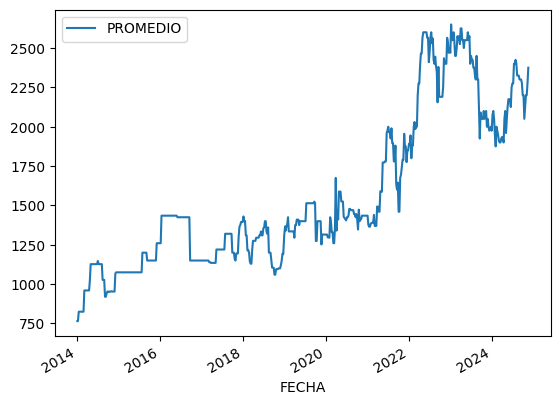

In [4]:
datos_emd = modo_1 + modo_2 + residuo
datos_emd.plot()

In [5]:
futuros = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Datos históricos Futuros maíz EE.UU..csv" )
futuros = futuros[["Fecha","Último"]]
futuros["Fecha"]=pd.to_datetime(futuros["Fecha"],dayfirst=True)
futuros.rename(columns={"Último":"Futuro"},inplace=True)
futuros["Futuro"] = futuros["Futuro"].str.replace(",",".").astype(float)
futuros.set_index("Fecha", inplace=True)
futuros.head()

,Futuro
Fecha,
2024-11-04,416.10
2024-11-01,414.50
2024-10-31,410.75
2024-10-30,411.50
2024-10-29,413.75


In [6]:
futuros_values = futuros.values
futuros_values = futuros_values.astype('float32')
futuros_scaler = MinMaxScaler(feature_range=(-1, 1))
futuros_escalada =  pd.DataFrame(futuros_scaler.fit_transform(futuros_values), columns=futuros.columns,index=futuros.index)

In [7]:
def add_lags(df,pasos):
    target_map = df['PROMEDIO'].to_dict()
    for i in range(pasos+1):
      df[f'retraso-{i}'] = df['PROMEDIO'].shift(i)
    df = df.drop(columns=["retraso-0"])
    df.dropna(inplace=True)
    return df

In [8]:
PASOS = 7
CARACTERISTICAS = [ "retraso-1", "retraso-2",	"retraso-3",	"retraso-4",	"retraso-5",	"retraso-6",	"retraso-7", "Futuro"]

In [9]:
def to_sup(modo):
  modo_values = modo.values
  modo_values = modo_values.astype('float32')
  modo_scaler = MinMaxScaler(feature_range=(-1, 1))

  modo_escalado =  pd.DataFrame(modo_scaler.fit_transform(modo_values), columns=modo.columns,index=modo.index)
  modo_sup = add_lags(modo_escalado, PASOS)
  modo_sup = pd.merge( modo_sup,futuros_escalada,left_index=True, right_index=True, how='inner')
  modo_sup.head(5)
  return modo_scaler, modo_sup

# Primer Modo

In [10]:
modo_1_scaler, modo_1_sup = to_sup(modo_1)
modo_1_sup.head()

,PROMEDIO,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7,Futuro
2014-02-19,-0.074062,-0.024696,0.024298,0.081641,0.156057,0.256265,0.081436,0.248481,-0.409028
2014-02-26,-0.132522,-0.074062,-0.024696,0.024298,0.081641,0.156057,0.256265,0.081436,-0.406236
2014-03-05,0.489056,-0.132522,-0.074062,-0.024696,0.024298,0.081641,0.156057,0.256265,-0.328060
2014-03-14,0.398721,0.489056,-0.132522,-0.074062,-0.024696,0.024298,0.081641,0.156057,-0.313169
2014-03-21,0.295612,0.398721,0.489056,-0.132522,-0.074062,-0.024696,0.024298,0.081641,-0.321545


In [11]:
total_datos=len(modo_1_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)

datos_entrenamiento_m1 = modo_1_sup[:division_entrenamiento]
datos_testeo_m1 = modo_1_sup[division_entrenamiento:total_datos]

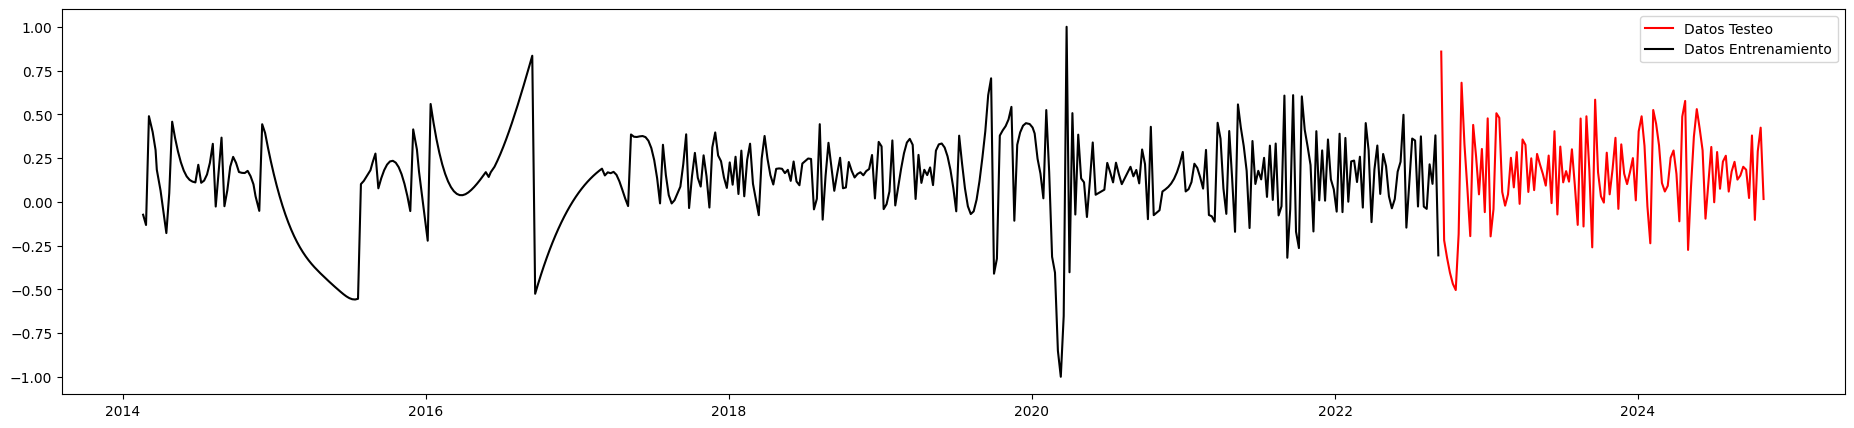

In [12]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_testeo_m1.index,datos_testeo_m1.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_entrenamiento_m1.index,datos_entrenamiento_m1.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.legend(loc = 'upper right')
plt.show()

In [13]:
modelo_1 = load("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Futuros_maiz/Modelos/XG_boost/XG_boost_m1.joblib")

In [14]:
X_train = datos_entrenamiento_m1[CARACTERISTICAS]
y_train = datos_entrenamiento_m1["PROMEDIO"]

X_test = datos_testeo_m1[CARACTERISTICAS]
y_test = datos_testeo_m1["PROMEDIO"]

modelo_1.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=0)

prediccion_modo_1 = modelo_1.predict(X_test)
recm = np.sqrt(mean_squared_error(prediccion_modo_1,y_test))
ecm = mean_squared_error(prediccion_modo_1,y_test)
mae = mean_absolute_error(prediccion_modo_1,y_test)
mape = mean_absolute_percentage_error(prediccion_modo_1,y_test)

print(f"El error cuadratico medio del modelo es {ecm}")
print(f"La raiz error cuadratico medio del modelo es {recm}")
print(f"El error absoluto medio del modelo es {mae}")
print(f"porcentaje de error absoluto medio del modelo es {mape} ")

El error cuadratico medio del modelo es 0.05570240691304207
La raiz error cuadratico medio del modelo es 0.23601357638835907
El error absoluto medio del modelo es 0.18349261581897736
porcentaje de error absoluto medio del modelo es 2.0435731410980225 


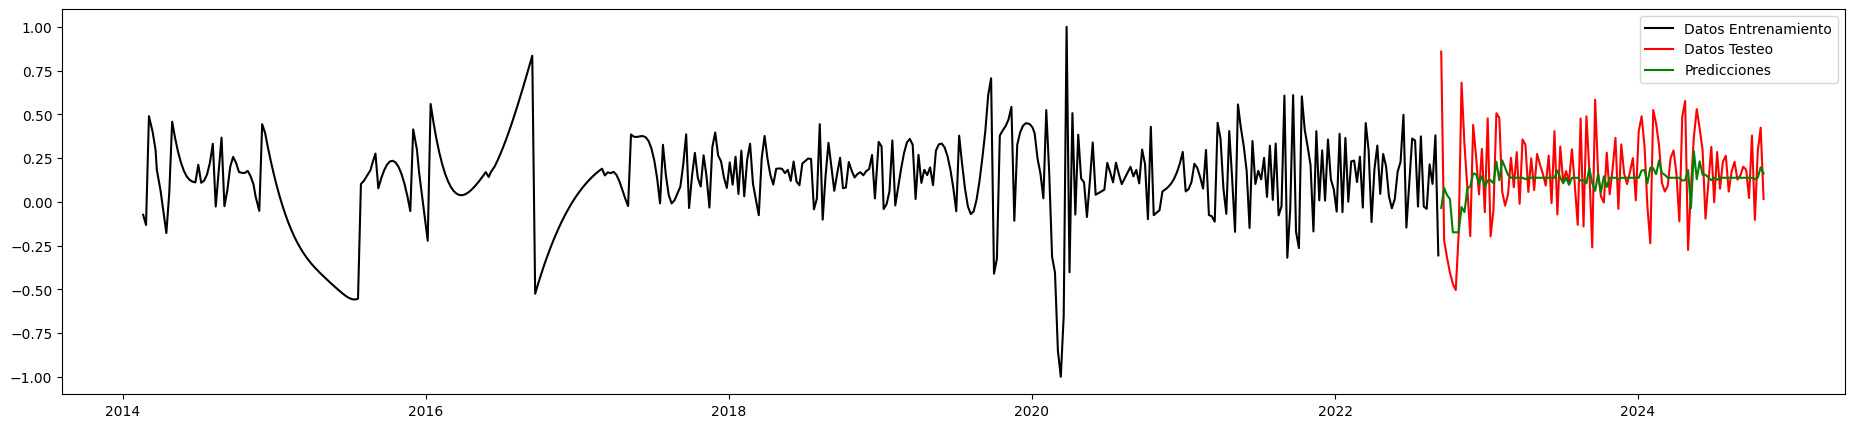

In [15]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m1.index,datos_entrenamiento_m1.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_testeo_m1.index,datos_testeo_m1.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_m1.index,prediccion_modo_1,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [16]:
prediccion_modo_1 = modo_1_scaler.inverse_transform(prediccion_modo_1.reshape(-1, 1))

# Modo 2

In [17]:
modo_2_scaler, modo_2_sup = to_sup(modo_2)
modo_2_sup.head()

,PROMEDIO,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7,Futuro
2014-02-19,0.126095,0.176095,0.224942,0.264819,0.287185,0.283285,0.244412,0.170529,-0.409028
2014-02-26,0.082692,0.126095,0.176095,0.224942,0.264819,0.287185,0.283285,0.244412,-0.406236
2014-03-05,0.052206,0.082692,0.126095,0.176095,0.224942,0.264819,0.287185,0.283285,-0.328060
2014-03-14,0.034905,0.052206,0.082692,0.126095,0.176095,0.224942,0.264819,0.287185,-0.313169
2014-03-21,0.028747,0.034905,0.052206,0.082692,0.126095,0.176095,0.224942,0.264819,-0.321545


In [18]:
total_datos=len(modo_2_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m2 = modo_2_sup[:division_entrenamiento]
datos_testeo_m2 = modo_2_sup[division_entrenamiento:total_datos]

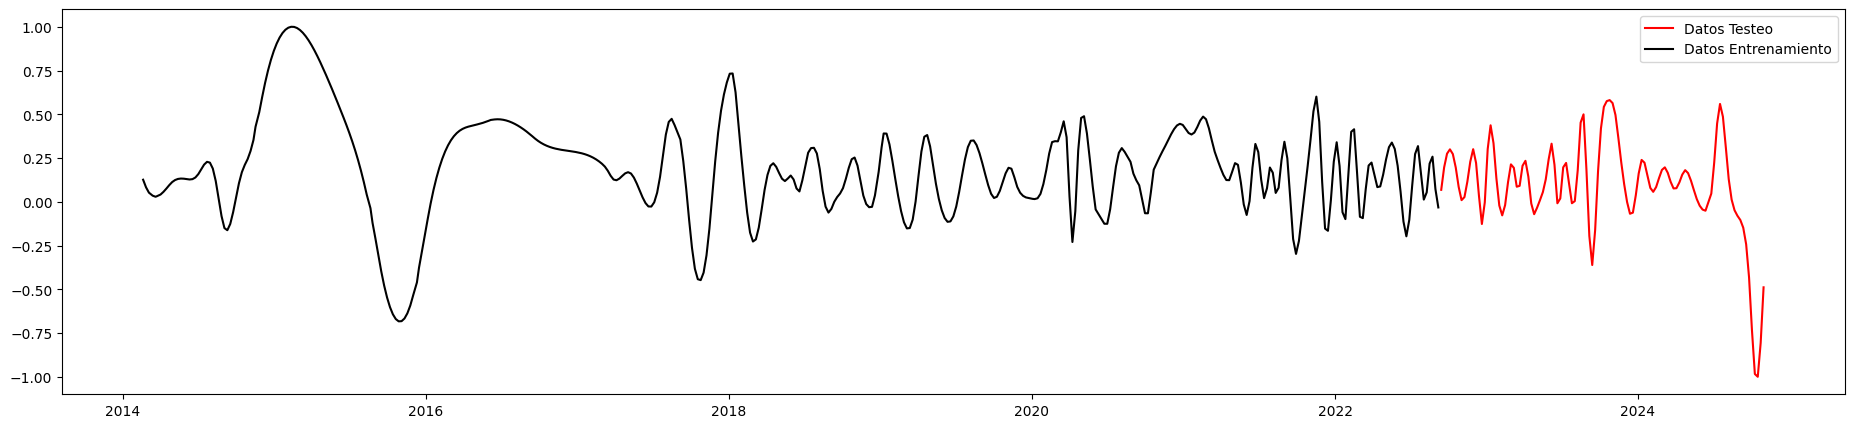

In [19]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_testeo_m2.index,datos_testeo_m2.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_entrenamiento_m2.index,datos_entrenamiento_m2.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.legend(loc = 'upper right')
plt.show()

In [20]:
modelo_2 = load("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Futuros_maiz/Modelos/XG_boost/XG_boost_m2.joblib")

In [21]:
X_train = datos_entrenamiento_m2[CARACTERISTICAS]
y_train = datos_entrenamiento_m2["PROMEDIO"]

X_test = datos_testeo_m2[CARACTERISTICAS]
y_test = datos_testeo_m2["PROMEDIO"]

modelo_2.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=0)

prediccion_modo_2 = modelo_2.predict(X_test)
recm = np.sqrt(mean_squared_error(prediccion_modo_2,y_test))
ecm = mean_squared_error(prediccion_modo_2,y_test)
mae = mean_absolute_error(prediccion_modo_2,y_test)
mape = mean_absolute_percentage_error(prediccion_modo_2,y_test)

print(f"El error cuadratico medio del modelo es {ecm}")
print(f"La raiz error cuadratico medio del modelo es {recm}")
print(f"El error absoluto medio del modelo es {mae}")
print(f"porcentaje de error absoluto medio del modelo")

El error cuadratico medio del modelo es 0.007376872934401035
La raiz error cuadratico medio del modelo es 0.08588872104883194
El error absoluto medio del modelo es 0.05925893411040306
porcentaje de error absoluto medio del modelo


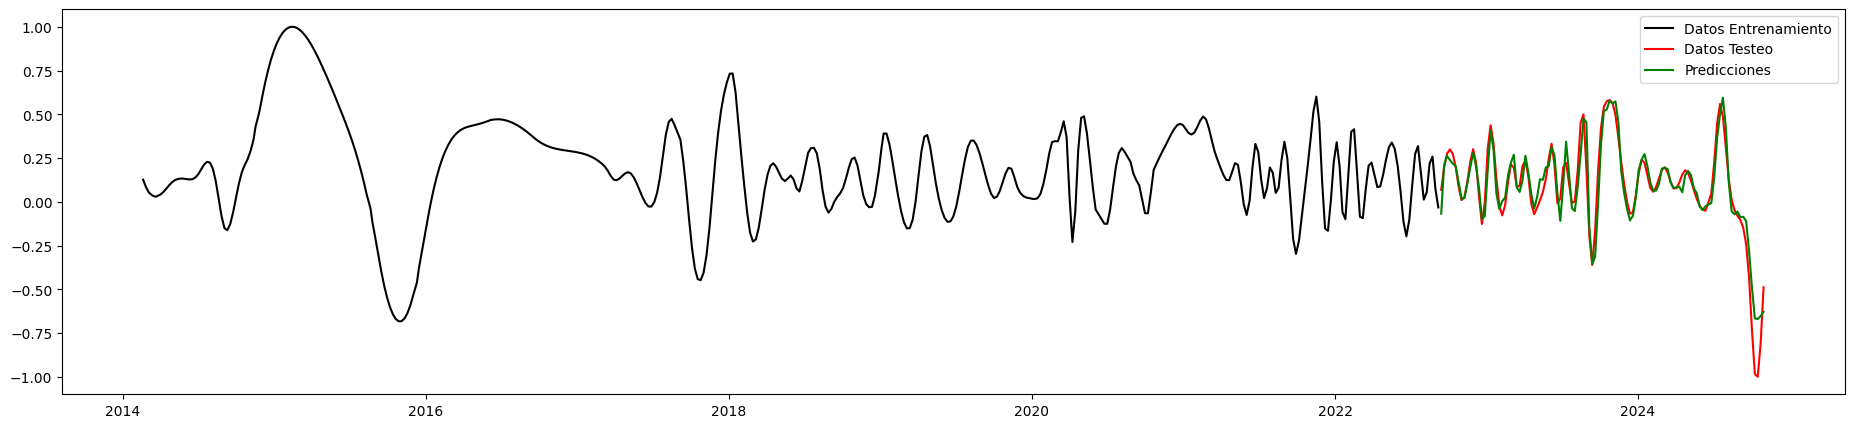

In [22]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m2.index,datos_entrenamiento_m2.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_testeo_m2.index,datos_testeo_m2.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_m2.index,prediccion_modo_2,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [23]:
prediccion_modo_2 = modo_2_scaler.inverse_transform(prediccion_modo_2.reshape(-1, 1))

# Residuo

In [24]:
residuo_scaler, residuo_sup = to_sup(residuo)
residuo_sup.head()

,PROMEDIO,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7,Futuro
2014-02-19,-0.856479,-0.879354,-0.901861,-0.923870,-0.945065,-0.965080,-0.983524,-1.000000,-0.409028
2014-02-26,-0.833353,-0.856479,-0.879354,-0.901861,-0.923870,-0.945065,-0.965080,-0.983524,-0.406236
2014-03-05,-0.810098,-0.833353,-0.856479,-0.879354,-0.901861,-0.923870,-0.945065,-0.965080,-0.328060
2014-03-14,-0.786837,-0.810098,-0.833353,-0.856479,-0.879354,-0.901861,-0.923870,-0.945065,-0.313169
2014-03-21,-0.763693,-0.786837,-0.810098,-0.833353,-0.856479,-0.879354,-0.901861,-0.923870,-0.321545


In [25]:
total_datos=len(residuo_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)

datos_entrenamiento_residuo = residuo_sup[:division_entrenamiento]
datos_testeo_residuo = residuo_sup[division_entrenamiento:total_datos]

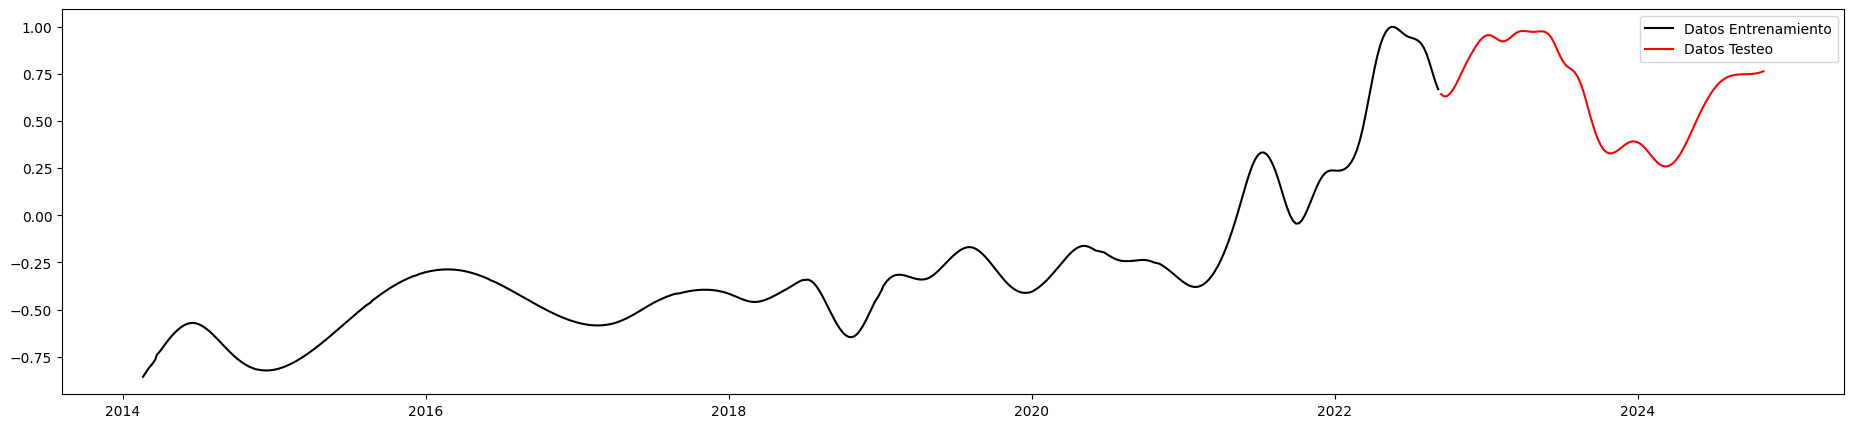

In [26]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_residuo.index,datos_entrenamiento_residuo.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_testeo_residuo.index,datos_testeo_residuo.PROMEDIO,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [27]:
modelo_residuo = load("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Futuros_maiz/Modelos/XG_boost/XG_boost_residuo.joblib")

In [28]:
X_train = datos_entrenamiento_residuo[CARACTERISTICAS]
y_train = datos_entrenamiento_residuo["PROMEDIO"]

X_test = datos_testeo_residuo[CARACTERISTICAS]
y_test = datos_testeo_residuo["PROMEDIO"]

modelo_residuo.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=0)

prediccion_residuo = modelo_residuo.predict(X_test)
recm = np.sqrt(mean_squared_error(prediccion_residuo,y_test))
ecm = mean_squared_error(prediccion_residuo,y_test)
mae = mean_absolute_error(prediccion_residuo,y_test)
mape = mean_absolute_percentage_error(prediccion_residuo,y_test)

print(f"El error cuadratico medio del modelo es {ecm}")
print(f"La raiz error cuadratico medio del modelo es {recm}")
print(f"El error absoluto medio del modelo es {mae}")
print(f"porcentaje de error absoluto medio del modelo es {mape}")

El error cuadratico medio del modelo es 0.004802118055522442
La raiz error cuadratico medio del modelo es 0.06929731369018555
El error absoluto medio del modelo es 0.05717351660132408
porcentaje de error absoluto medio del modelo es 0.16399270296096802


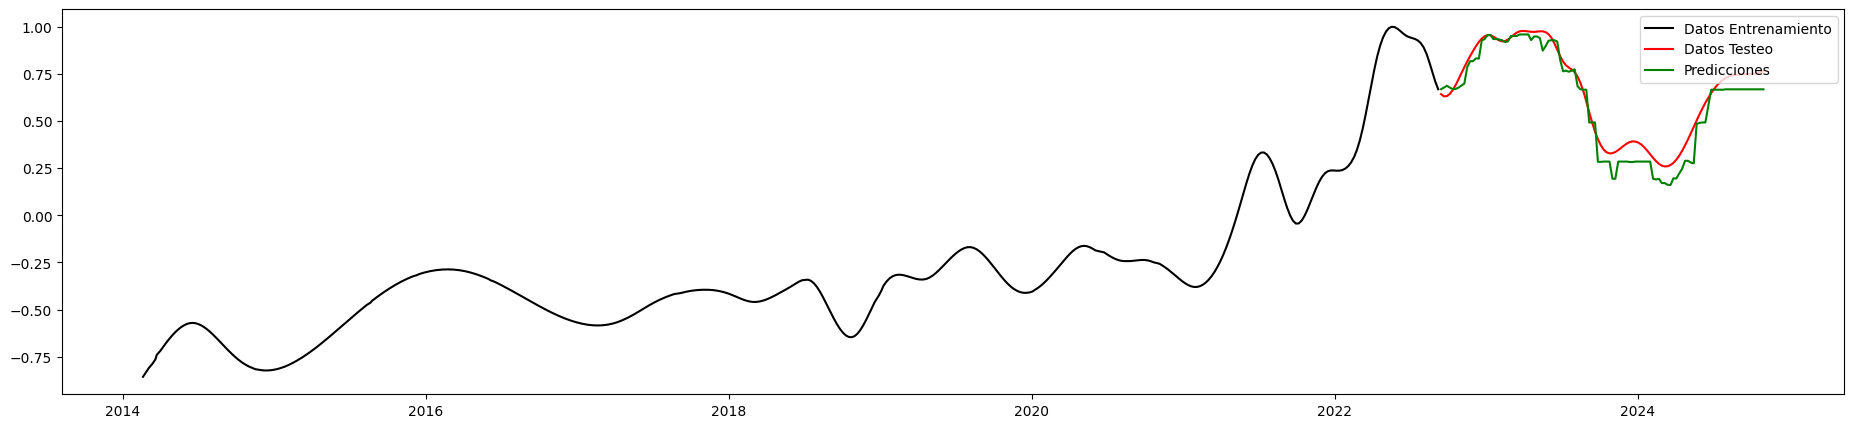

In [29]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_residuo.index,datos_entrenamiento_residuo.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_testeo_residuo.index,datos_testeo_residuo.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_residuo.index,prediccion_residuo,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [30]:
prediccion_residuo = residuo_scaler.inverse_transform(prediccion_residuo.reshape(-1, 1))

# Ensemble

In [31]:
predicciones_emd = prediccion_modo_1 + prediccion_modo_2 + prediccion_residuo

In [32]:
total_datos=len(datos_emd.PROMEDIO)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)

datos_entrenamiento = datos_emd[:division_entrenamiento]
datos_testeo = datos_emd[division_entrenamiento:total_datos]


In [33]:
ecm = mean_squared_error( predicciones_emd,datos_testeo.PROMEDIO[:-2])
recm =np.sqrt(mean_squared_error( predicciones_emd,datos_testeo.PROMEDIO[:-2]))
eam = mean_absolute_error( predicciones_emd,datos_testeo.PROMEDIO[:-2])
EPAM = mean_absolute_percentage_error(predicciones_emd,datos_testeo.PROMEDIO[:-2])


#Imprimir las metricas de validacion del modelo
print ( f'El error cuadratico medio del modelo es: {round(ecm,2)} ' )
print ( f'La raiz del error cuadratico medio del modelo es: {round(recm,2)} ' )
print ( f'el error absoluto medio del modelo es: {round(eam,2)} ' )
print(f"Error porcentual absoluto medio del modelo es: {EPAM} o {round(EPAM * 100 , 2)} %")

El error cuadratico medio del modelo es: 9319.56 
La raiz del error cuadratico medio del modelo es: 96.54 
el error absoluto medio del modelo es: 77.19 
Error porcentual absoluto medio del modelo es: 0.036632513549760694 o 3.66 %


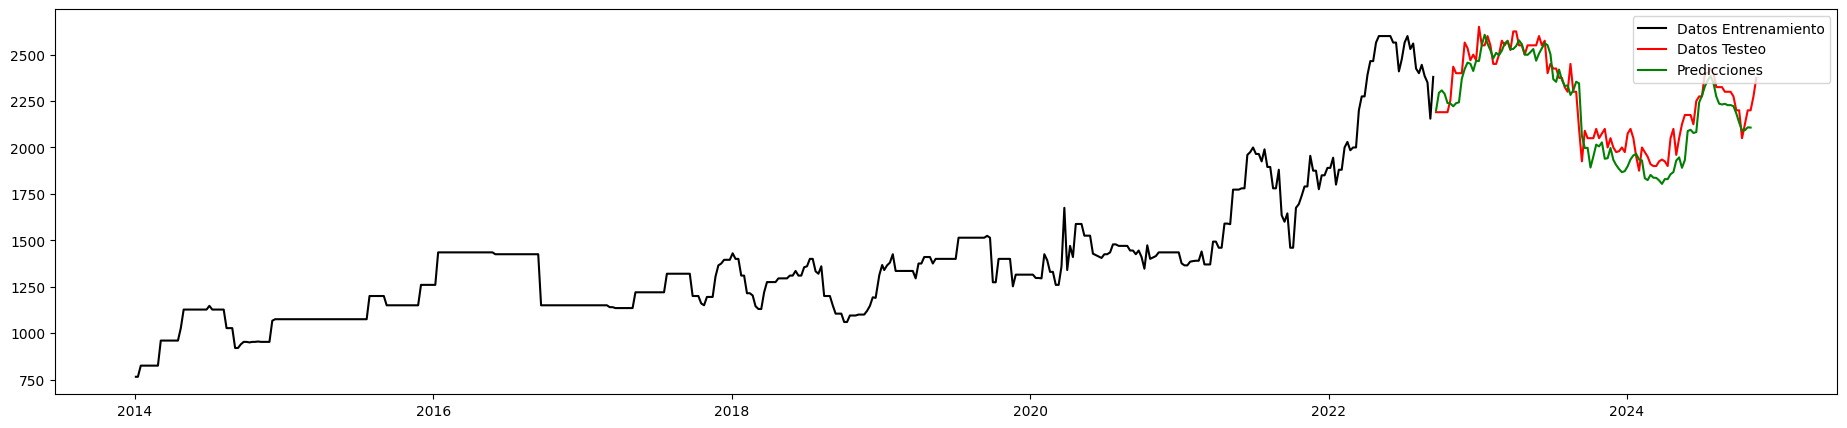

In [34]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_testeo.index,datos_testeo.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo.index[:-2],predicciones_emd,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

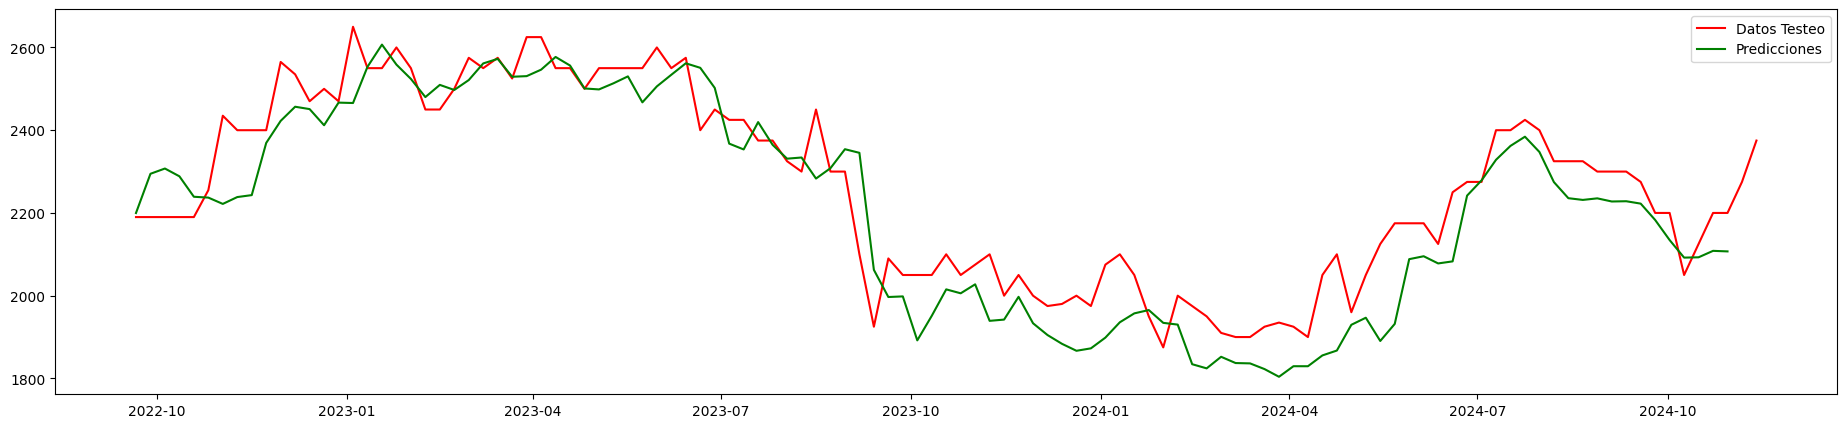

In [35]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_testeo.index,datos_testeo.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo.index[:-2],predicciones_emd,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()


In [40]:
testeo = pd.DataFrame(predicciones_emd,index=datos_testeo.index[:-2],columns=['PROMEDIO'])
testeo.to_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/otras regiones/Modelado/Monteria/Resultados/testeo_XGboost.csv",index=True)